In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [4]:
df_train = pd.read_parquet('/home/jupyter/datasphere/project/data/train_dataset_hackaton2023_train.gzip')
df_test = pd.read_parquet('/home/jupyter/datasphere/project/data/hackaton2023_test.gzip')

df_test['date_diff_post'] = 0
df_test['buy_post'] = 0

In [5]:
def has_ws(x):
    return x in ['Отдельно стоящий с внешней зоной', 'Отдельно стоящий без внешней зоны', 'Отдельно стоящий', 'Фудкорт с туалетом']

def is_food_court(x):
    return 'Фудкорт' in x

In [31]:
def preprocess(df):
    # df = df.drop_duplicates()

    df['discounts'] = df['revenue'] == 1
    df['has_ws'] = df['format_name'].apply(has_ws)
    df['is_food_court'] = df['format_name'].apply(is_food_court)

    data_check_agg = df.groupby(['customer_id', 'startdatetime']).agg({
        'revenue': ['sum', 'count'], 
        'discounts': 'sum',
        'has_ws': 'first',
        'is_food_court': 'first',
        'buy_post': 'first',
        'date_diff_post': 'first',
    }).reset_index()

    data_check_agg.columns = [f'{header}_{stat}' if header == 'revenue' else header for header, stat in data_check_agg.columns]
    data_check_agg = data_check_agg.rename({'revenue_sum': 'revenue', 'revenue_count': 'positions_count'}, axis=1)

    data_check_agg['delta'] = data_check_agg.groupby('customer_id')['startdatetime'].diff() 

    data_check_agg['delta_hours'] = (data_check_agg['delta'].dt.total_seconds() // (60*60)).fillna(0)
    data_check_agg['delta_days'] = (data_check_agg['delta'].dt.total_seconds() // (24*60*60)).fillna(0)

    data_check_agg = data_check_agg.drop('delta', axis=1)
    data_check_agg['month'] = data_check_agg['startdatetime'].dt.month
    data_check_agg['day_of_week'] = data_check_agg['startdatetime'].dt.day_of_week
    data_check_agg['hour'] = data_check_agg['startdatetime'].dt.hour

    data_cust_agg = data_check_agg.groupby('customer_id').agg({
        'revenue': ['mean', 'median', 'std', 'max', 'min', 'count', 'sum'],
        'positions_count': ['mean', 'median', 'std', 'max', 'min'],
        'discounts': ['mean', 'median', 'std', 'max', 'min', 'sum'],
        'delta_hours': ['mean', 'median', 'std', 'max'],
        'delta_days': ['mean', 'median', 'std', 'max'],
        'hour': ['mean', 'median', 'std', 'max', 'min'],
        'startdatetime': ['min', 'max'],
        'has_ws': 'mean',
        'is_food_court': 'mean',
        'buy_post': 'first',
        'date_diff_post': 'first',
    }).reset_index()

    data_cust_agg.columns = [f'{header}_{stat}' for header, stat in data_cust_agg.columns]

    data_cust_agg['recency'] = (data_cust_agg['startdatetime_max'] - data_cust_agg['startdatetime_min']).dt.days
    data_cust_agg['T'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_min']).dt.days
    data_cust_agg['days_from_last_purchase'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_max']).dt.days
    data_cust_agg['lambda'] = data_cust_agg['revenue_count'] / (data_cust_agg['recency'] + 1)
    data_cust_agg = data_cust_agg.drop(['startdatetime_min', 'startdatetime_max'], axis=1)
    
    return data_cust_agg

In [32]:
data_train_val = preprocess(df_train)

In [33]:
data_train_val.head()

,customer_id_,revenue_mean,revenue_median,revenue_std,revenue_max,revenue_min,revenue_count,revenue_sum,positions_count_mean,positions_count_median,positions_count_std,positions_count_max,positions_count_min,discounts_mean,discounts_median,discounts_std,discounts_max,discounts_min,discounts_sum,delta_hours_mean,delta_hours_median,delta_hours_std,delta_hours_max,delta_days_mean,delta_days_median,delta_days_std,delta_days_max,hour_mean,hour_median,hour_std,hour_max,hour_min,has_ws_mean,is_food_court_mean,buy_post_first,date_diff_post_first,recency,T,days_from_last_purchase,lambda
0,29891,203.494000,199.960,123.170275,439.98,1.00,25,5087.35,1.360000,1.0,0.860233,4,1,0.12,0.0,0.331662,1,0,3,55.240000,24.0,72.502460,266.0,1.920000,1.0,2.998889,11.0,11.200000,9.0,4.699291,19,0,1.000000,0.000000,1,9.0,57,239,181,0.431034
1,30477,227.024000,229.990,124.933425,499.95,44.99,25,5675.60,2.440000,1.0,1.916594,7,1,0.24,0.0,0.663325,2,0,6,49.400000,23.0,60.578462,216.0,1.520000,0.0,2.518597,9.0,11.080000,10.0,2.797618,16,8,1.000000,0.000000,1,10.0,51,301,249,0.480769
2,31426,391.399583,344.985,334.849322,1079.97,1.00,24,9393.59,3.583333,3.5,1.909169,8,1,0.25,0.0,0.531610,2,0,6,49.708333,34.5,46.635944,164.0,1.666667,1.0,1.809796,6.0,16.041667,15.0,3.263489,22,9,0.000000,1.000000,1,4.0,50,81,31,0.470588
3,44491,128.725000,59.980,144.471912,344.97,49.97,4,514.90,2.500000,2.5,0.577350,3,2,0.00,0.0,0.000000,0,0,0,166.750000,11.5,318.351352,644.0,6.500000,0.0,13.000000,26.0,20.500000,21.0,1.732051,22,18,0.000000,0.250000,1,42.0,27,52,24,0.142857
4,44939,554.943333,554.940,49.985000,604.93,504.96,3,1664.83,8.333333,9.0,1.154701,9,7,2.00,2.0,0.000000,2,2,6,123.333333,172.0,107.598017,198.0,5.000000,7.0,4.358899,8.0,16.333333,16.0,5.507571,22,11,0.333333,0.666667,1,9.0,15,234,219,0.187500


In [11]:
%pip install lifetimes

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for dill>=0.2.6 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [29]:
#  expected average lifetime value of our customers

from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(data_train_val['revenue_count'], data_train_val['revenue_sum'])
print (ggf) 

<lifetimes.GammaGammaFitter: fitted with 500000 subjects, p: 1.43, q: 3.77, v: 5352.77>


In [15]:
data_train_val.dtypes

customer_id_                 int64
revenue_mean               float64
revenue_median             float64
revenue_std                float64
revenue_max                float64
revenue_min                float64
revenue_count                int64
revenue_sum                float64
positions_count_mean       float64
positions_count_median     float64
positions_count_std        float64
positions_count_max          int64
positions_count_min          int64
discounts_mean             float64
discounts_median           float64
discounts_std              float64
discounts_max                int64
discounts_min                int64
delta_hours_mean           float64
delta_hours_median         float64
delta_hours_std            float64
delta_hours_max            float64
delta_days_mean            float64
delta_days_median          float64
delta_days_std             float64
delta_days_max             float64
hour_mean                  float64
hour_median                float64
hour_std            

In [46]:
# estimate the average transaction value:

print(ggf.conditional_expected_average_profit(data_train_val['revenue_count'], data_train_val['revenue_sum']).head())

0    4919.487794
1    5465.354078
2    8897.029668
3    1247.638022
4    2094.111411
dtype: float64


In [34]:
data_test = preprocess(df_test)

In [35]:
X_train = data_train_val.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)
y_train_class = data_train_val['buy_post_first']
y_train_reg = data_train_val['date_diff_post_first']

X_test = data_test.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)

In [38]:
model_class = LGBMClassifier(
    n_estimators=1000, 
    reg_alpha=20, 
    max_depth=3, 
    importance_type='gain', 
    reg_lambda=20, 
    class_weight={0: 0.7, 1:0.3},
    verbose=-1,
)

res = cross_val_score(model_class, X_train, y_train_class, scoring='roc_auc')
print(f'ROC-AUC: {res.mean():.3f} ± {res.std():.3f}')

ROC-AUC: 0.751 ± 0.000


In [39]:
model_class.fit(X_train, y_train_class)

LGBMClassifier(class_weight={0: 0.7, 1: 0.3}, importance_type='gain',
               max_depth=3, n_estimators=1000, reg_alpha=20, reg_lambda=20,
               verbose=-1)

<Axes: >

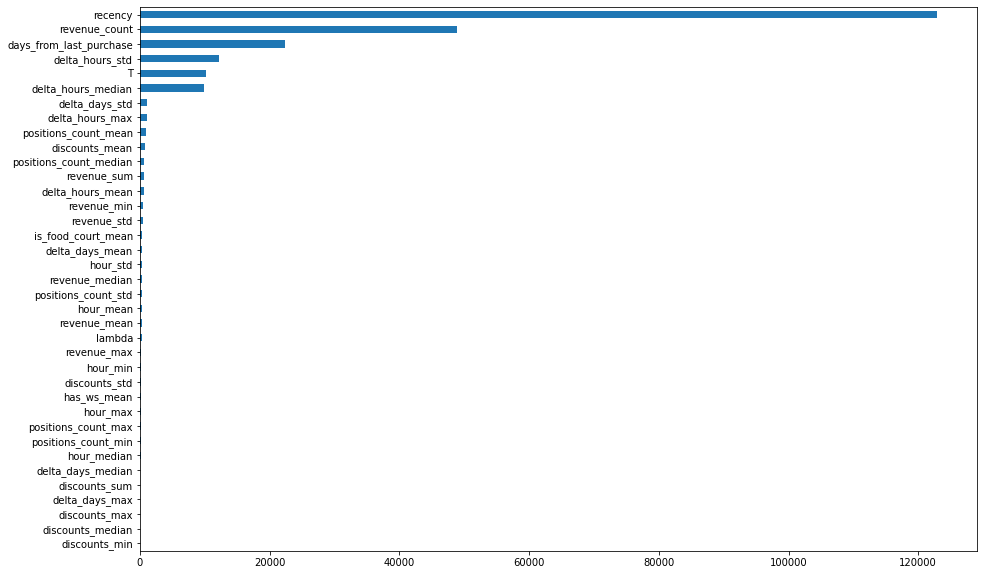

In [42]:
plt.figure(figsize=(15, 10))
pd.Series(model_class.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh')

In [43]:
model_reg = LGBMRegressor(
    n_estimators=1000, 
    reg_alpha=20, 
    max_depth=3, 
    importance_type='gain', 
    reg_lambda=20,
    verbose=-1,
)

res = cross_val_score(model_reg, X_train, y_train_reg.fillna(0), scoring='neg_root_mean_squared_error')
print(f'RMSE: {-res.mean():.3f} ± {res.std():.3f}')

RMSE: 16.675 ± 0.207


In [44]:
model_reg.fit(X_train, y_train_reg.fillna(0))

LGBMRegressor(importance_type='gain', max_depth=3, n_estimators=1000,
              reg_alpha=20, reg_lambda=20, verbose=-1)